In [81]:
import numpy as np
from scipy.optimize import dual_annealing
import pulp
import pandas as pd
import os
import random
from wmape import WMAPE
from order_generator import OrderGenerator
from order_merger import OrderMerger
import math
import matplotlib.pyplot as plt

In [82]:
random.seed(42)

In [83]:
def objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day):
    # Apply the current allocation to the orders dataframe
    orders_df['site'] = current_allocation

    # Aggregate the orders for the initial and target lead days
    aggregated_initial_df = OrderMerger.aggregate_items(orders_df, initial_day)
    aggregated_target_df = OrderMerger.aggregate_items(target_orders_df, target_day)

    # Merge the aggregated dataframes
    merged_df = OrderMerger.merge_allocation(aggregated_initial_df, aggregated_target_df, initial_day, target_day)

    # Calculate WMAPE
    _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{target_day}', f'lead_{initial_day}')
    return wmape_site

In [84]:
def cooling_schedule(initial_temp, alpha, step):
    return initial_temp * (alpha ** step)


def generate_neighbor(current_allocation, orders_df, eligibility_dict):
    new_allocation = current_allocation.copy()
    max_attempts = 100  # Limit the number of attempts to find a valid swap

    for _ in range(max_attempts):
        idx1, idx2 = random.sample(range(len(new_allocation)), 2)

        # Check eligibility for idx1
        order_id1 = orders_df.iloc[idx1]['order_id']
        items1 = orders_df[orders_df['order_id'] == order_id1]['item_id'].tolist()
        site1 = new_allocation[idx2]  # Swap site for idx1

        if all(item in eligibility_dict[site1] for item in items1):
            # Check eligibility for idx2
            order_id2 = orders_df.iloc[idx2]['order_id']
            items2 = orders_df[orders_df['order_id'] == order_id2]['item_id'].tolist()
            site2 = new_allocation[idx1]  # Swap site for idx2

            if all(item in eligibility_dict[site2] for item in items2):
                # Perform the swap if both are eligible
                new_allocation[idx1], new_allocation[idx2] = new_allocation[idx2], new_allocation[idx1]
                break

    return new_allocation



def acceptance_probability(current_energy, new_energy, temperature):
    if new_energy < current_energy:
        return 1.0
    else:
        return math.exp((current_energy - new_energy) / temperature)


def simulated_annealing(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, initial_temp, final_temp, alpha, max_iter):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    temp = initial_temp
    step = 0

    while temp > final_temp and step < max_iter:
        new_allocation = generate_neighbor(current_allocation, orders_df, eligibility_dict)
        new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        temp = cooling_schedule(initial_temp, alpha, step)
        step += 1

    return best_allocation, best_energy

In [85]:
allocation_dir = 'allocations'

allocation_0 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_0.csv')
allocation_5 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_5.csv')
allocation_10 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_10.csv')

In [86]:
allocation_dir = 'allocations'
merged_dir = 'merged'
sa_allocation_dir = 'sa_allocations'
sa_merged_dir = 'sa_merged'

# Create the merged directory if it doesn't exist
os.makedirs(sa_allocation_dir, exist_ok=True)
os.makedirs(sa_merged_dir, exist_ok=True)

In [103]:
def perform_simulated_annealing(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict):
    # Load the initial allocation dataframe for the first lead day
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    
    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{lead_days[0]}.csv', index=False)
    
    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i-1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')
        current_allocation = current_df['site'].values
        current_energy = objective_function(current_allocation, current_df, previous_df, current_day, previous_day)
        best_allocation, best_energy = simulated_annealing(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, initial_temp, final_temp, alpha, max_iter)
        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation
        
        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv', index=False)
        
        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()
        

In [104]:
def calculate_wmape_for_all_days(lead_days):
    wmape_site_values = []
    wmape_global_values = []

    final_day = lead_days[-1]
    final_day_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{final_day}.csv')
    aggregated_final_day = OrderMerger.aggregate_items(final_day_df, final_day)
    
    for day in lead_days[:-1]:
        current_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{day}.csv')
        aggregated_current_day = OrderMerger.aggregate_items(current_df, day)
        
        merged_df = OrderMerger.merge_allocation(aggregated_current_day, aggregated_final_day, day, final_day)
        
        site_df, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{day}', f'lead_{final_day}')
        global_df, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{day}', f'lead_{final_day}')
        
        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)
        
        # Save the merged dataframe
        merged_df.to_csv(f'{sa_merged_dir}/sa_merged_lead_day_{day}_to_{final_day}.csv', index=False)
    
    # Add 0 for lead day 0
    wmape_site_values.append(0)
    wmape_global_values.append(0)
    
    return wmape_site_values, wmape_global_values


In [105]:
def plot_wmape(lead_days, wmape_site_values, wmape_global_values):
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days, wmape_site_values, linestyle='-', color='b', label='WMAPE Site')
    ax.plot(lead_days, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')

    # Add labels and title
    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Different Lead Days')
    ax.set_xticks(lead_days)
    ax.legend()

    # Invert x-axis to have 0 at the end
    ax.invert_xaxis()

    plt.show()


In [106]:

lead_days = list(range(18, -1, -1))  # Define the lead days from 18 to 0
initial_temp = 5230
final_temp = 1
alpha = 0.95
max_iter = 1e7

eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')

# Perform simulated annealing for consecutive lead days
perform_simulated_annealing(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict)


0.4243035190615836
0.42320381231671556
0.445125348189415
0.4447539461467038
0.4282055659894144
0.42718115075977464
0.3958584987057808
0.3896462467644521
0.4476102941176471
0.446875
0.4398793818318884
0.4361100640784018
0.42708526843767414
0.4196544677689021
0.4083796940194715
0.4083796940194715
0.42404036763380787
0.4200756893133898
0.445328785294675
0.4449497820731476
0.4461100569259962
0.44003795066413665
0.43902844784561634
0.43703210780236235
0.4032991078942939
0.40094260225551254
0.4050370881490426
0.4050370881490426
0.40258175559380377
0.3991394148020654
0.48193229364777485
0.4785089387599848
0.4495103005741304
0.44511989192840257
0.5071523936677474
0.5044821666984551


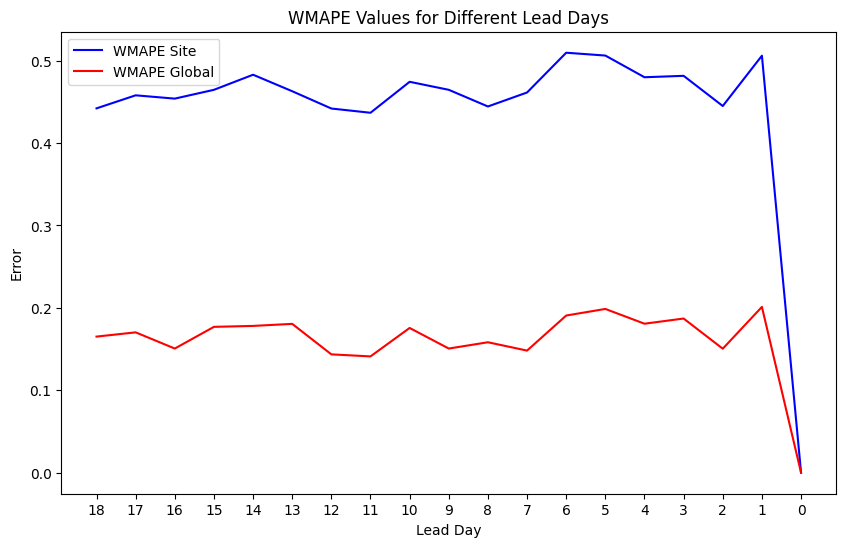

In [94]:
# Calculate WMAPE for all days
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days)

# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)